In [105]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

In [106]:
# read pickle file from collect_dataset/dataset.pkl
with open('collect_dataset/dataset_1.pkl', 'rb') as f:
    #pkl.dump((speed, steering, obs, step_reward, done, info, timestep), f)
    data = []
    while True:
        try:
            data.append(pkl.load(f))
        except EOFError:
            break

In [107]:
print(len(data))

2314


In [108]:
data[0]

(1.0,
 0.3054325580596924,
 {'ego_idx': 0,
  'scans': [array([2.87953737, 2.87825169, 2.94648735, ..., 0.97953912, 0.96721278,
          1.02446817])],
  'poses_x': [1.2000256913746439],
  'poses_y': [5.000040011945328],
  'poses_theta': [1.0],
  'linear_vels_x': [0.00951],
  'linear_vels_y': [0.0],
  'ang_vels_z': [0.0],
  'collisions': array([0.]),
  'lap_times': array([0.02]),
  'lap_counts': array([0.])},
 0.01,
 False,
 {'checkpoint_done': array([False])},
 0)

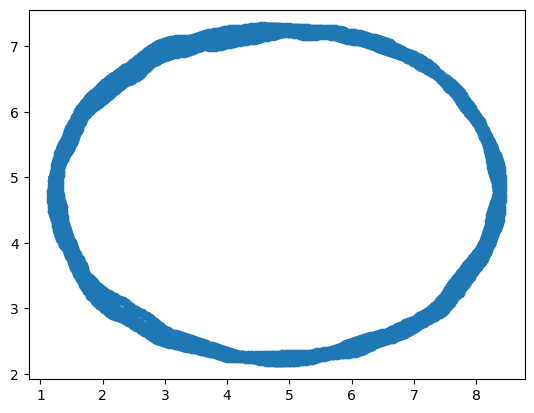

In [109]:
# plot for each data point the poses_x and poses_y in a scatter plot
# poses x are at data[i][2]['poses_x']

# scatter plot
y_pose = [data[i][2]['poses_y'][0] for i in range(0, len(data))]
x_pose = [data[i][2]['poses_x'][0] for i in range(0, len(data))]
# plt scatter plot
plt.scatter(x_pose, y_pose)
plt.show()


In [110]:
# we need to calulate the middle line of the track
# first read in the map and the corresponding map yaml file
import yaml
import cv2

with open('collect_dataset/ellipse_map2.yaml') as file:
    conf_dict = yaml.load(file, Loader=yaml.FullLoader)
# load the image from the yaml file
map = cv2.imread("collect_dataset/"+conf_dict['image'], cv2.IMREAD_GRAYSCALE)

In [111]:
# read in ellipse_map2.csv
import csv
with open('collect_dataset/ellipse_map2.csv', newline='') as csvfile:
    centerline = list(csv.reader(csvfile))

In [112]:
# extract the first column as x and the second column as y
# throw away first row
x_c = [float(centerline[i][0]) for i in range(2, len(centerline))]
y_c = [float(centerline[i][1]) for i in range(2, len(centerline))]
# add a point at the end to close the loop. same y as last point and x interpolated between last and first point
y_c.append(y_c[-1])
x_c.append((x_c[0]+x_c[-1])/2)


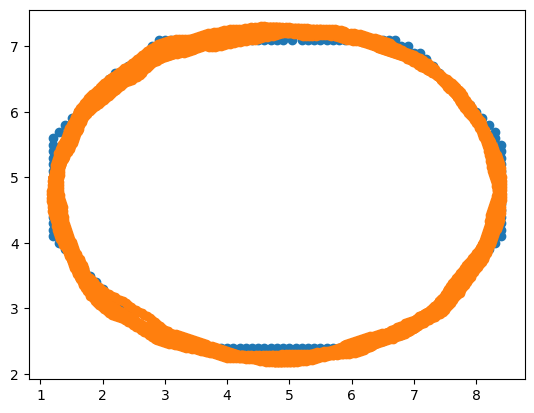

In [113]:
# scatter plot
plt.scatter(x_c, y_c)
plt.scatter(x_pose, y_pose)
plt.show()


In [114]:
# for each pose point find the closest point on the centerline
x_c = np.array(x_c)
y_c = np.array(y_c)
x_pose = np.array(x_pose)
y_pose = np.array(y_pose)

In [115]:
from scipy.spatial.distance import cdist
centerline_points = np.stack((x_c, y_c), axis=-1)
centerline_points = np.flip(centerline_points,axis=0)
# flip the centerline points to get the correct order
pose_points = np.stack((x_pose, y_pose), axis=-1)
distances = cdist(pose_points, centerline_points)

In [116]:
# Get the indices of the closest centerline points
closest_indices = np.argmin(distances, axis=1)
reward = closest_indices/len(centerline_points)

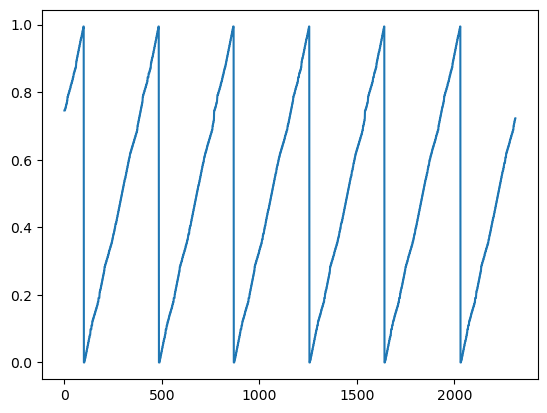

In [117]:
# plot the reward
plt.plot(reward)
plt.show()


In [141]:
# print the indices where there is a rapud change in reward
# this is where the car is crossing the start/finish line
# we can use this to split the dataset into multiple trajectories
d = np.diff(reward)
rapid_changes = np.where(np.abs(d) > 0.5)[0] +1
# split into trajectories at these indices
trajectories = np.split(reward, rapid_changes)
# throw away first and last trajectory
trajectories = trajectories[1:-1]

In [142]:
print(len(trajectories))


5


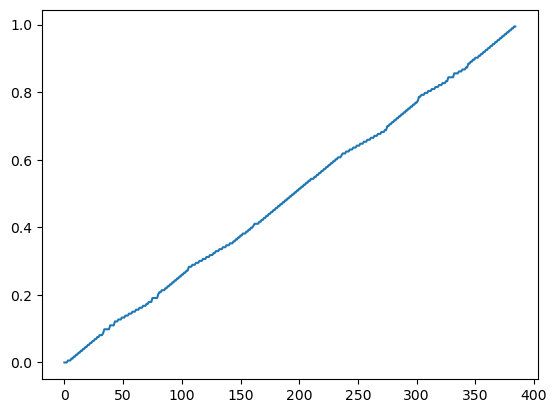

In [145]:
# plot the first reward trajectory
plt.plot(trajectories[0])
plt.show()

In [148]:
gamma = 0.99  # discount factor

for rewards in trajectories:
    discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
    cumulative_rewards = 0

    for i in reversed(range(len(rewards))):
        cumulative_rewards = rewards[i] + gamma * cumulative_rewards
        discounted_rewards[i] = cumulative_rewards

    print(cumulative_rewards)
    print(len(rewards))

22.693861534337636
385
22.602760966146555
384
22.70276751286855
388
22.638522327190497
385
22.612186447442355
390
